# Выделение групп пользователей на основе поведения

**Цель:** выделить группы пользователей мобильного приложения на основе показателей Retention Rate; общего времени, проведенного в приложении; частоты действий; конверсии в целевое действие (просмотр контактов). 

### План проекта:<a class="tocSkip"> 

1. Предобработка данных;
   
   1.1 Загрузка данных и изучение общей информации;
   
   1.2 Приведение столбцов к нужным типам;
   
   1.3 Поиск дубликатов и заполнение пропусков при необходимости;
   
   1.4 Добавление столбцов с рассчетом общего времени, проведенного в приложении, для каждого пользователя;
    
   
2. Исследовательский анализ данных
   
   2.1 Анализ общего времени, проведенного в приложении (построение гистограммы, рассчет среднего и медианы)
   
   2.2 Частотный анализ действий пользователей в приложении (построение гистограмм, анализ распределений);
    
   
3. Рассчет метрик
   
    3.1 Рассчет Retention Rate 
   
    3.2 Рассчет конверсии

    
4. Сегментация пользователей на основе метрик, общего времени и частоты действий

    
5. Проверка гипотез
    
    5.1 Проверка гипотезы о разнице конверсий между пользователями, установившими приложение по ссылке из Yandex и Google (z-тест для сравнения долей)
    
    5.2 Проверка гипотезы о разнице конверсий между пользователями с различной частотой использования приложения (z-тест для сравнения долей)
    
    
5. Выводы и рекомендации

**Описание данных:**

Датасет **_** содержит колонки:
* `event.time` — время совершения
* `event.name` — название события
* `user.id` — идентификатор пользователя

Датасет **_** содержит колонки:
* `userId` — идентификатор пользователя
* `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
* `advert_open` — открытие карточки объявления
* `photos_show` — просмотр фотографий в объявлении
* `tips_show` — пользователь увидел рекомендованные объявления
* `tips_click` — пользователь кликнул по рекомендованному объявлению
* `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
* `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
* `map` — пользователь открыл карту размещенных объявлений
* `search_1` — `search_7` — разные события, связанные с поиском по сайту
* `favorites_add` — добавление объявления в избранное



## Предобработка данных
### Загрузка данных и изучение общей информации

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np  
from scipy import stats as st
import numpy as np
import math as mth
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [6]:
df = pd.read_csv(' ')
df_sources = pd.read_csv(' ')

dfs = [df, df_sources]
for i in dfs:
    display(i.head(5))
    display(i.info())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

#### Вывод

Мы видим, что в полученных данных нет пропусков, типы данных нуждаются в преобразовании. 

### Приведение столбцов к нужным типам

In [7]:
# преобразуем столбец со временем события в нужный тип, отдельно создадим столбец для даты,
# его тоже приведем к нужному типу
df['event.time'] = pd.to_datetime(df['event.time'], 
                                  format='%Y.%m.%d %H:%M:%S')
df['event_date'] = df['event.time'].dt.date
df['event_date'] = pd.to_datetime(df['event_date'], 
                                  format='%Y.%m.%d')
display(df.head())
df.info()

,event.time,event.name,user.id,event_date
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event.time  74197 non-null  datetime64[ns]
 1   event.name  74197 non-null  object        
 2   user.id     74197 non-null  object        
 3   event_date  74197 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 2.3+ MB


#### Вывод

Столбец с датой был приведен к нужному типу, также был создан столбец отдельно с датой события, он также был приведен к нужному типу. 

### Поиск дубликатов и заполнение пропусков

In [8]:
# проверим наличие пропусков и дубликатов
for i in dfs:
    display(i.isnull().sum())
    i.duplicated().sum()

event.time    0
event.name    0
user.id       0
event_date    0
dtype: int64

userId    0
source    0
dtype: int64

In [9]:
# заменим значения "show_contacts" на "contacts_show"
df['event.name'] = df['event.name'].replace('show_contacts', 
                                            'contacts_show')
df['event.name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

#### Вывод

Дубликатов не было обнаружено. Значения "show_contacts" были заменены на "contacts_show", так как обозначают одно и то же событие. 

### Добавление столбца с рассчетом общего времени, проведенного в приложении

In [15]:
# создадим срез с первыми и последними логами пользователя, посчитаем длительность
sess_duration = df.groupby('user.id')['event.time'].agg(['min', 'max'])
sess_duration.set_axis(['first_visit', 'last_visit'], axis='columns', inplace=True)
sess_duration['duration'] = sess_duration['last_visit'] - sess_duration['first_visit']
sess_duration.reset_index(inplace=True)

# создадим столбцы, где посчитаем длительность в часах и секундах 
# на случай того, если длительность меньше 1 часа или 1 дня
sess_duration['duration_hours'] = sess_duration['duration'].astype('timedelta64[h]')
sess_duration['duration_sec'] = sess_duration['duration'].astype('timedelta64[s]')
sess_duration

,user.id,first_visit,last_visit,duration,duration_hours,duration_sec
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,2019-10-22 11:30:52.807203,14 days 21:51:06.817844,357.0,1288266.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,2019-11-03 17:12:09.708771,14 days 19:37:35.859002,355.0,1280255.0
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,2019-11-01 14:19:17.860053,0 days 00:24:42.475025,0.0,1482.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,2019-10-31 21:42:15.606558,12 days 23:28:10.051506,311.0,1121290.0
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,2019-10-29 02:17:12.342406,3 days 09:32:31.079042,81.0,293551.0
...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27.414960,2019-10-26 19:53:51.993545,13 days 03:42:24.578585,315.0,1136544.0
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49.997044,2019-10-07 20:33:42.135500,0 days 00:00:52.138456,0.0,52.0
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35.199237,2019-10-23 11:52:55.577369,0 days 00:01:20.378132,0.0,80.0
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:33.867145,2019-10-28 07:17:52.646652,6 days 14:38:18.779507,158.0,571098.0


#### Вывод

Был добавлен столбцех с общим временем, проведенным пользователем в приложении, а также столбец с этим временем в секундах и часах. 

### Вывод

* Был приведен к нужному типу столбец с датой и временем лога;
* Был создан столбец с датой лога;
* Значения "show_contacts" были заменены на "contacts_show"; 
* Было посчитано общее время, проведенное пользователем в приложении (и переведено в часы и секунды).

## Исследовательский анализ данных
### Анализ общего времени, проведенного в приложении

In [11]:
# создадим функцию для построения гистограмм
def histogram(data, column, name, labelx):
    data[column].hist(bins=50)
    plt.title(name)
    plt.xlabel(labelx)
    plt.ylabel('Частота')
    plt.show()

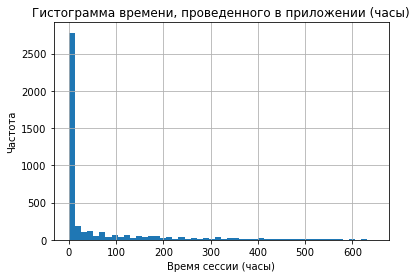

53.69205683671092

In [12]:
# построим гистограмму времени, проведенного в приложении, в часах
# ниже выведено количество сессий, продолжительность которых равна 0 часам

histogram(sess_duration, 'duration_hours', 
          'Гистограмма времени, проведенного в приложении (часы)', 
          'Время сессии (часы)')
(len(sess_duration.query('duration_hours == 0')) / len(sess_duration))*100

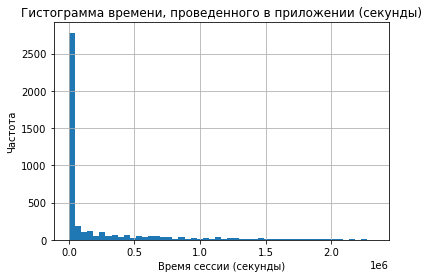

1.5606801770323782

In [13]:
# построим гистограмму времени в секундах
# ниже выведено количество сессий, которые равны 0 секунд

histogram(sess_duration, 'duration_sec', 
          'Гистограмма времени, проведенного в приложении (секунды)', 
          'Время сессии (секунды)')
(len(sess_duration.query('duration_sec == 0')) / len(sess_duration))*100

In [18]:
print('Среднее общее время, проведенное в приложении = ', 
      (sess_duration['duration_sec'].mean()), 'секунд')
print('')
print('Среднее общее время, проведенное в приложении = ', 
      (sess_duration['duration_sec'].mean()/60), 'минут')
print('')
print('Среднее общее время, проведенное в приложении = ', 
      ((sess_duration['duration_sec'].mean()/60)/1440), 'дней')

Среднее общее время, проведенное в приложении =  227658.41928721173 секунд

Среднее общее время, проведенное в приложении =  3794.3069881201955 минут

Среднее общее время, проведенное в приложении =  2.634935408416802 дней


#### Вывод

Видно, что большая часть пользователей проводят в приложении меньше 1 часа. Поэтому в дальнейшем будем описаться на продолжительность сессии в секундах, чтобы не получать перекоса значений. 
В среднем, пользователи проводят в приложении 2,6 дня или 227658 секунд. 

### Частотный анализ действий пользователей в приложении

In [29]:
forT_rot = df.melt(
    id_vars=['event.time', 'user.id', 'event_date'], value_vars=['event.name']
)
forT_rot = forT_rot.rename(
    columns={'value': 'event.name'}
)
forT_rot.to_csv('forT_rot.csv', index=False)
forT_rot

,event.time,user.id,event_date,variable,event.name
0,2019-10-07 00:00:00.431357,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,event.name,advert_open
1,2019-10-07 00:00:01.236320,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,event.name,tips_show
2,2019-10-07 00:00:02.245341,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,event.name,tips_show
3,2019-10-07 00:00:07.039334,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,event.name,tips_show
4,2019-10-07 00:00:56.319813,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,event.name,advert_open
...,...,...,...,...,...
74192,2019-11-03 23:53:29.534986,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,event.name,tips_show
74193,2019-11-03 23:54:00.407086,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,event.name,tips_show
74194,2019-11-03 23:56:57.041825,20850c8f-4135-4059-b13b-198d3ac59902,2019-11-03,event.name,search_1
74195,2019-11-03 23:57:06.232189,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,event.name,tips_show


In [19]:
# посчитаем количество действий каждого типа и построим график

events_freq = (df.groupby('event.name').agg({'user.id':'count'})
                         .sort_values('user.id', ascending=False)
                         .reset_index()
              )
events_freq.set_axis(['event.name', 'frequency'], axis='columns', inplace=True)
events_freq

,event.name,frequency
0,tips_show,40055
1,photos_show,10012
2,advert_open,6164
3,contacts_show,4529
4,map,3881
5,search_1,3506
6,favorites_add,1417
7,search_5,1049
8,tips_click,814
9,search_4,701


In [26]:
events_freq['% of total'] = events_freq['frequency'] / sum(events_freq['frequency'])
events_freq.to_csv('forT.csv', index=False)

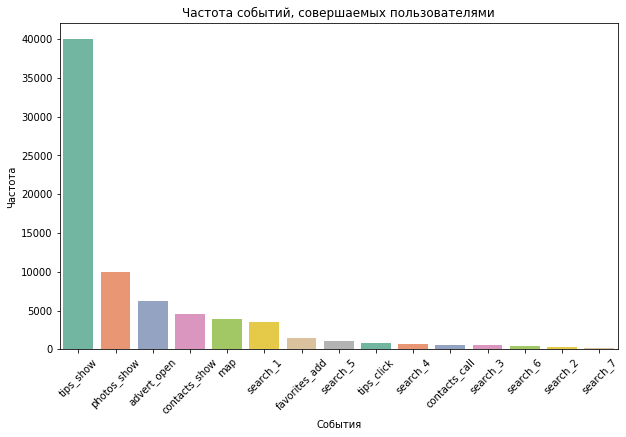

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(data=events_freq,
            y='frequency',
            x='event.name',
            palette='Set2', 
            ci=None)
plt.title('Частота событий, совершаемых пользователями')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.xlabel('События')
plt.show()

Видим, что чаще всего пользователям предъявляют рекомендованные объявления, они просматривают фотографии в объявлении и открывают карточки объявления. Реже всего совершаются события, связанные с поиском по сайту. 

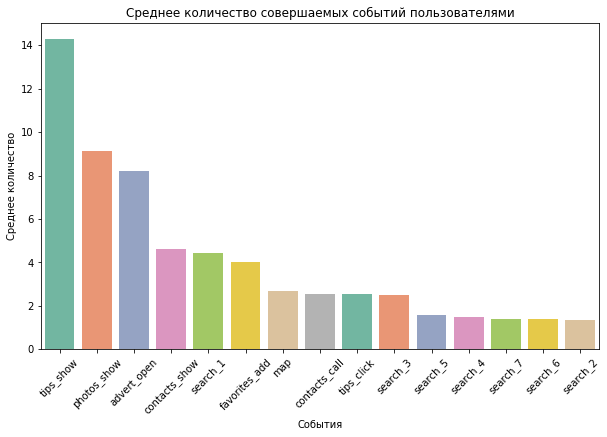

,events,frequency
0,tips_show,14.300250
1,photos_show,9.143379
2,advert_open,8.207723
3,contacts_show,4.616718
4,search_1,4.454892
5,favorites_add,4.037037
6,map,2.665522
7,contacts_call,2.539906
8,tips_click,2.527950
9,search_3,2.509615


In [13]:
# посчитаем среднее количество событий разного типа на одного пользователя
# сгруппируем события по названию и посчитаем количество совершенных действий пользователями
byuser = df.groupby(['event.name', 'user.id']).agg({'event.time':'count'})
byuser.reset_index(inplace=True)
byuser.set_axis(['events', 'users', 'frequency'], 
                axis='columns', 
                inplace=True)

 
# создадим датасет, куда внесем результаты
events_by_user = (byuser.groupby('events').agg({'frequency':'mean'})
                        .sort_values(by='frequency', ascending=False)
                        .reset_index()
                 )


# построим график и выведем таблицу с результатами
plt.figure(figsize=(10,6))
sns.barplot(data=events_by_user,
            y='frequency',
            x='events',
            palette='Set2', 
            ci=None)
plt.title('Среднее количество совершаемых событий пользователями')
plt.ylabel('Среднее количество')
plt.xticks(rotation=45)
plt.xlabel('События')
plt.show()

events_by_user

Полученные результаты похожи на общие частоты. Чаще всего пользователям предъявляют рекомендованные объявления, и они просматривают фотографии в объявлении и открывают карточки объявления. Реже всего совершаются события, связанные с поиском по сайту.

### Вывод

* Большая часть пользователей проводят в приложении меньше 1 часа, поэтому в дальнейшем будем опираться на продолжительность сессии в секундах;
* В среднем, пользователи проводят в приложении 2,6 дня или 227658 секунд;
* Чаще всего пользователям предъявляют рекомендованные объявления, и они просматривают фотографии в объявлении и открывают карточки объявления;
* Реже всего совершаются события, связанные с поиском по сайту.

## Расчет метрик
### Рассчет Retention Rate

In [14]:
# определим количество дней, за которые у нас есть логи, чтобы понять, на какие когорты
# разбивать пользователей

df['event_date'].max() - df['event_date'].min()

Timedelta('27 days 00:00:00')

У нас есть данные за 27 дней, поэтому допустимо брать за период построения когорт 1 день. 

In [15]:
# соединим исходную таблицу с таблицей с указанием времени, проведенного  в приложении

cohorts = pd.merge(df, sess_duration, on='user.id')

# округлим дату первого визита до даты 
cohorts['firstvisit_date'] = pd.DatetimeIndex(cohorts['first_visit']).date
cohorts['firstvisit_date'] = pd.to_datetime(cohorts['firstvisit_date'], 
                                            format='%Y.%m.%d')

# посчитаем lifetime, округляя, чтобы не потерять данные

cohorts['lifetime'] = cohorts['event_date'] - cohorts['firstvisit_date']
cohorts['lifetime'] = cohorts['lifetime'] / np.timedelta64(1,'D')
cohorts['lifetime'] = cohorts['lifetime'].apply(np.round).astype('int') 

cohorts

,event.time,event.name,user.id,event_date,first_visit,last_visit,duration,duration_hours,duration_sec,firstvisit_date,lifetime
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07 00:00:00.431357,2019-10-07 00:18:42.917148,00:18:42.485791,0.0,1122.0,2019-10-07,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07 00:00:00.431357,2019-10-07 00:18:42.917148,00:18:42.485791,0.0,1122.0,2019-10-07,0
2,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07 00:00:00.431357,2019-10-07 00:18:42.917148,00:18:42.485791,0.0,1122.0,2019-10-07,0
3,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07 00:00:00.431357,2019-10-07 00:18:42.917148,00:18:42.485791,0.0,1122.0,2019-10-07,0
4,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07 00:00:00.431357,2019-10-07 00:18:42.917148,00:18:42.485791,0.0,1122.0,2019-10-07,0
...,...,...,...,...,...,...,...,...,...,...,...
74192,2019-11-03 23:46:47.068179,map,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,2019-11-03 23:46:47.068179,2019-11-03 23:47:50.087645,00:01:03.019466,0.0,63.0,2019-11-03,0
74193,2019-11-03 23:46:58.914787,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,2019-11-03 23:46:47.068179,2019-11-03 23:47:50.087645,00:01:03.019466,0.0,63.0,2019-11-03,0
74194,2019-11-03 23:47:01.232230,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,2019-11-03 23:46:47.068179,2019-11-03 23:47:50.087645,00:01:03.019466,0.0,63.0,2019-11-03,0
74195,2019-11-03 23:47:47.475102,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,2019-11-03 23:46:47.068179,2019-11-03 23:47:50.087645,00:01:03.019466,0.0,63.0,2019-11-03,0


In [16]:
# посчитаем количество пользователей в каждой когорте
cohorts_users = (cohorts.groupby(['firstvisit_date','lifetime'])
                 .agg({'user.id':'nunique'})
                 .reset_index()
                )

# выясним исходное количество пользователей в когорте (на 0 неделю)
initial_users_count = (cohorts.query('lifetime == 0')
                              .groupby('firstvisit_date')
                              .agg({'user.id':'count'})
                      )
initial_users_count = (initial_users_count.reset_index()
                                          .rename(columns={'user.id':'cohort_users'})
                      )

# соединим с данными об исходном количестве пользователей
cohorts_users = cohorts_users.merge(initial_users_count,on='firstvisit_date') 
cohorts_users

,firstvisit_date,lifetime,user.id,cohort_users
0,2019-10-07,0,204,2545
1,2019-10-07,1,37,2545
2,2019-10-07,2,21,2545
3,2019-10-07,3,22,2545
4,2019-10-07,4,14,2545
...,...,...,...,...
399,2019-11-01,1,15,944
400,2019-11-01,2,6,944
401,2019-11-02,0,97,811
402,2019-11-02,1,15,811


In [17]:
# посчитаем retention, поделив текущее количество пользователей на изначальное 
cohorts_users['retention'] = cohorts_users['user.id']/cohorts_users['cohort_users']

# свобдная таблица для построения тепловой карты, сгруппируем по когортам, для каждого месяца
# lifetime посчитаем сумму retention
retention_pivot = cohorts_users.pivot_table(index='firstvisit_date',
                                            columns='lifetime',
                                            values='retention',
                                            aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
firstvisit_date,,,,,,,,,,,,,,,,,,,,,
2019-10-07,0.080157,0.014538,0.008251,0.008644,0.005501,0.004715,0.003143,0.006287,0.005108,0.003929,...,0.002358,0.003143,0.000786,0.001572,0.003143,0.002358,0.001572,0.003929,0.001572,0.001179
2019-10-08,0.081623,0.014663,0.009775,0.008309,0.002933,0.002933,0.005376,0.003910,0.005376,0.004399,...,0.000978,0.002933,0.003910,0.001466,0.001955,0.002933,0.002444,0.002444,0.002444,NaN
2019-10-09,0.111604,0.010780,0.009512,0.006341,0.006341,0.008878,0.006341,0.006341,0.006341,0.005707,...,0.001268,0.003171,0.001902,0.001268,0.003171,0.000634,0.001902,0.003171,NaN,NaN
2019-10-10,0.098639,0.013605,0.007370,0.010204,0.007370,0.009070,0.006236,0.007370,0.006236,0.005669,...,0.003968,0.002834,0.001701,0.003401,0.002268,0.001701,0.001701,NaN,NaN,NaN
2019-10-11,0.101341,0.008942,0.008197,0.013413,0.009687,0.006706,0.005961,0.007452,0.002235,NaN,...,0.003726,0.002981,0.002981,0.002981,0.002235,0.002235,NaN,NaN,NaN,NaN
2019-10-12,0.085793,0.017159,0.010295,0.008922,0.005491,0.006177,0.008922,0.006863,0.006177,0.005491,...,0.003432,0.002745,0.001373,0.004804,0.004804,NaN,NaN,NaN,NaN,NaN
2019-10-13,0.083333,0.014640,0.007320,0.004505,0.006194,0.005068,0.003378,0.006757,0.003941,0.005068,...,0.002252,0.001689,0.000563,0.002815,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-14,0.088137,0.014769,0.008099,0.008576,0.009052,0.006193,0.004764,0.004764,0.004764,0.004764,...,0.002382,0.000476,0.001906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-15,0.098153,0.014776,0.010026,0.008971,0.005805,0.005277,0.006332,0.006860,0.008443,0.003166,...,0.002639,0.002111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# приведем дату к удобному виду
retention_pivot.index = retention_pivot.index.strftime('%Y-%m-%d')

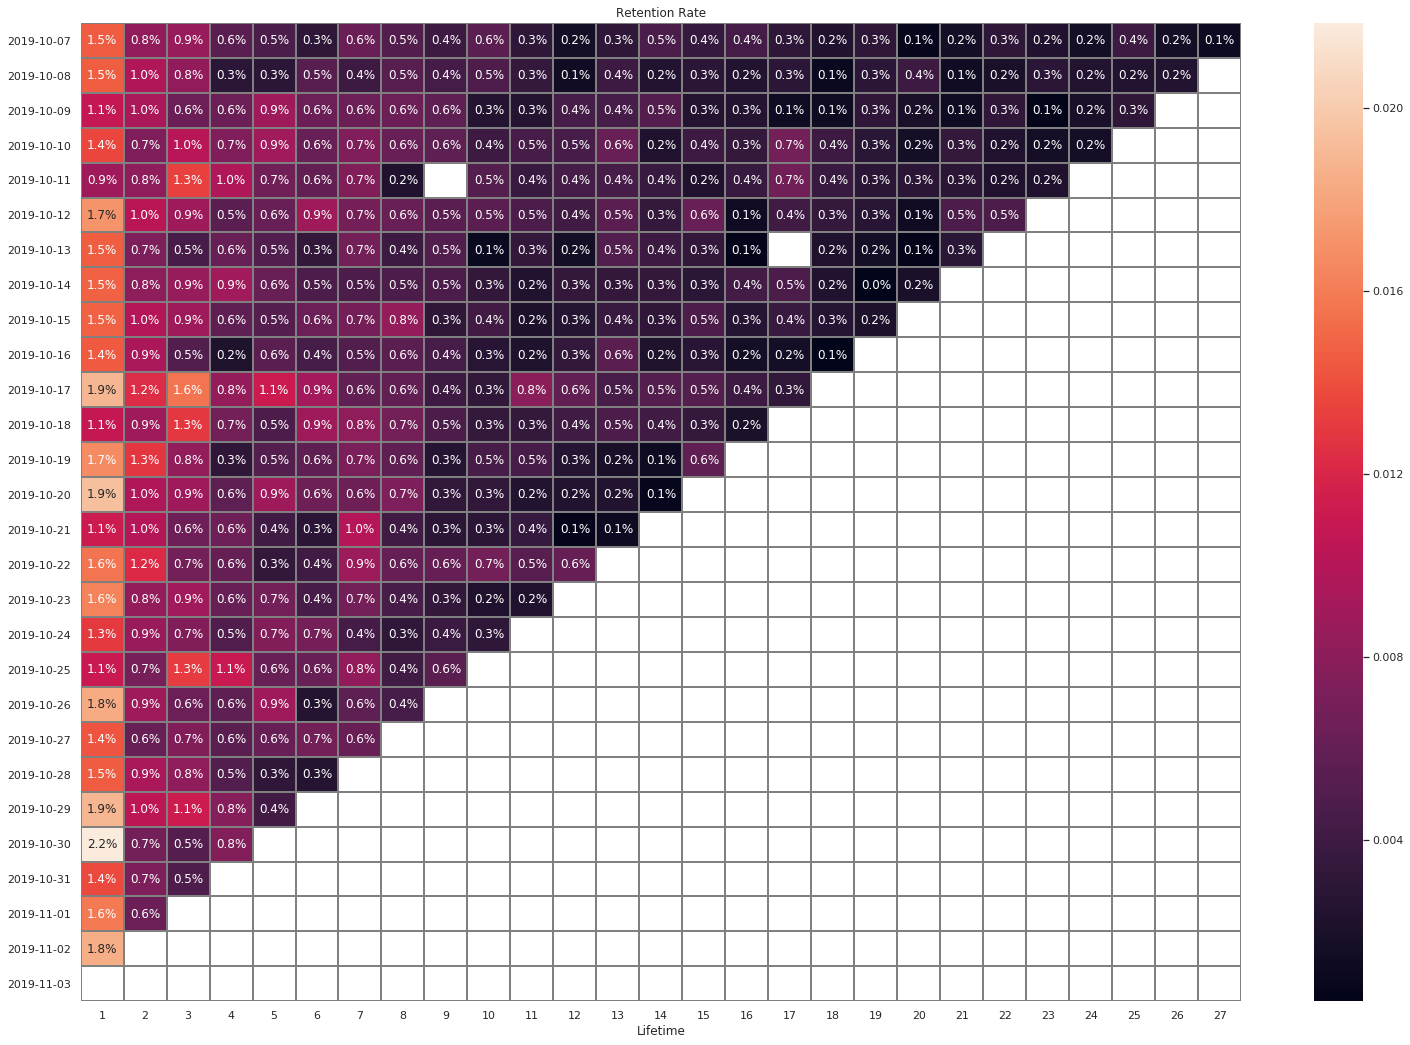

In [19]:
# построим тепловую карту, в данных отрежем первый столбец (с 0 лайфтайм),
# чтобы цветное отображение было наглядным
sns.set(style='white')
plt.figure(figsize=(26, 18))
plt.title('Retention Rate')
ax = sns.heatmap(retention_pivot.loc[:, '1': '27'], 
                 fmt= '.1%', 
                 annot=True, 
                 linewidths=1, 
                 linecolor='gray')
ax.set_xlabel('Lifetime')
plt.show()

#### Вывод

В целом, наблюдается снижение RR с течением времени жизни когорты. Одна когорты 2019-10-12, 2019-10-19, 2019-10-22 демонстируют не такое большое снижение RR. Этот факт требует дальнейшего анализа. Необходимо понять, какие группы пользователей находятся в этих когортах и почему у них больше коэффициент возврата. 

В некоторых когортах иногда наблюдается всплеск RR с последующим падением. Видим это в когортах 2019-10-11, 2019-10-17, 2019-10-21, 2019-10-25. Происходит всплеск на 3-4 день после начала пользования приложением. 

### Рассчет конверсии

In [20]:
# переименуем столбец с Id пользователя в таблице с источниками и соединим два исходных датасета
df_sources = df_sources.rename(columns={'userId':'user.id'})

all_df = pd.merge(df, df_sources, on='user.id')
all_df

,event.time,event.name,user.id,event_date,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
3,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
4,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
...,...,...,...,...,...
74192,2019-11-03 23:46:47.068179,map,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,google
74193,2019-11-03 23:46:58.914787,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,google
74194,2019-11-03 23:47:01.232230,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,google
74195,2019-11-03 23:47:47.475102,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03,google


In [21]:
# посчитаем общее количество пользователей, пришедших из каждого источника
all_users = all_df.groupby('source').agg({'user.id':'nunique'})
all_users = (all_users.rename(columns={'user.id':'all_users'})
                      .reset_index()
            )

all_df = all_df.rename(columns={'event.name':'event'})

# посчитаем целевых пользователей, то есть тех, кто совершил целевое действие - просмотр контактов
goal_users = (all_df.query('event == "contacts_show"')
                        .groupby('source')
                        .agg({'user.id':'nunique'})
             )
goal_users = (goal_users.rename(columns={'user.id':'goal_users'})
                        .reset_index()
             )

# соедними таблицы с общим количеством и целевыми пользователями, посчитаем конверсию
conversion = pd.merge(all_users, 
                      goal_users, 
                      on='source')
conversion['conversion'] = conversion['goal_users']/conversion['all_users']
conversion

,source,all_users,goal_users,conversion
0,google,1129,275,0.243578
1,other,1230,228,0.185366
2,yandex,1934,478,0.247156


#### Вывод

Была рассчитана конверсия пользователей, установивших приложение из Google и Yandex.

## Сегментация пользователей на основе метрик, общего времени и частоты действий

Проведем сегментацию клиентов на основе длительности сессий и выполнения\невыполнения целевого действия. Для этого используем иерархическую кластеризацию. 

In [22]:
# узнаем тех пользователей, кто хоть раз смотрел контакты в каком-то объявлении
df = df.rename(columns={'event.name':'event'})
who_contacts = (df.query('event == "contacts_show"')
                  .groupby('user.id').agg({'event.time':'count'})
               )

# присвоим им значение 1
who_contacts['contacts'] = (who_contacts['event.time'] >= 1).astype(int)

# соединим с информацией о длительности сессий
sess_duration = pd.merge(sess_duration, who_contacts, on='user.id', how='outer')

# заполним пропуски нулями
sess_duration['contacts'] = sess_duration['contacts'].fillna(0)
sess_duration.head()

,user.id,first_visit,last_visit,duration,duration_hours,duration_sec,event.time,contacts
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,2019-10-22 11:30:52.807203,14 days 21:51:06.817844,357.0,1288266.0,NaN,0.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,2019-11-03 17:12:09.708771,14 days 19:37:35.859002,355.0,1280255.0,11.0,1.0
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,2019-11-01 14:19:17.860053,0 days 00:24:42.475025,0.0,1482.0,NaN,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,2019-10-31 21:42:15.606558,12 days 23:28:10.051506,311.0,1121290.0,NaN,0.0
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,2019-10-29 02:17:12.342406,3 days 09:32:31.079042,81.0,293551.0,3.0,1.0


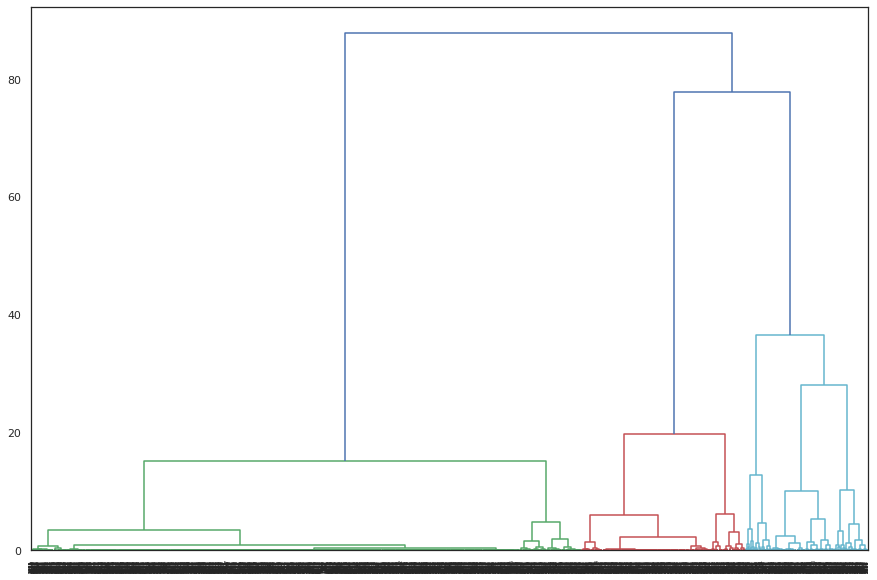

In [23]:
# создадим датасет с признаками, по которым будем кластеризовать
X = sess_duration.loc[:, ['duration_sec', 'contacts']]

# стандартизация
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# агломеративная кластеризация и вывод дендрограммы
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Видим, что выделяется 3 кластера. Создадим модель, которая разделит данные на 3 группы и добавим наимнования кластеров в датасет. Посчитаем описательные статистики. 

In [24]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 3)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
sess_duration['cluster_sec'] = labels

# выводим статистику по значениям наших признаков по кластеру
sess_duration.groupby('cluster_sec')['duration_sec', 'contacts'].agg(['count', 'mean'])


duration_sec               contacts          
                   count          mean    count      mean
cluster_sec                                              
0                   2996  7.488592e+04     2996  0.000000
1                    871  1.859596e+05      871  1.000000
2                    426  1.387344e+06      426  0.258216

Мы видим, что пользователи разбиты на 3 группы:
* 2996 человек попали в первый кластер, их среднее время пользования = 74885.92 сек (20.8 часов) и эти пользователи не совершают целевое действией;
* 871 человек попали во второй кластер, их среднее время = 185959.6 (51.7 часов) и они чаще не совершают целевое действие;
* 426 человек попадают в третий кластер, они пользуются в среднем по 1387344 секунд (385 часов) и они совершают целевое действие.

Аналогично проведем кластеризацию на основе частоты совершаемых действий и совершения\несовершения целевого действия. 

In [25]:
# добавим значения о тех, кто совершил целевое, заполним 0 пропуски 

freqs_users = pd.merge(df.groupby('user.id').agg({'event':'count'}), 
                       who_contacts, 
                       on='user.id', 
                       how='outer')
freqs_users['contacts'] = freqs_users['contacts'].fillna(0)
freqs_users.head()

,event,event.time,contacts
user.id,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,NaN,0.0
00157779-810c-4498-9e05-a1e9e3cedf93,71,11.0,1.0
00463033-5717-4bf1-91b4-09183923b9df,10,NaN,0.0
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,NaN,0.0
00551e79-152e-4441-9cf7-565d7eb04090,8,3.0,1.0


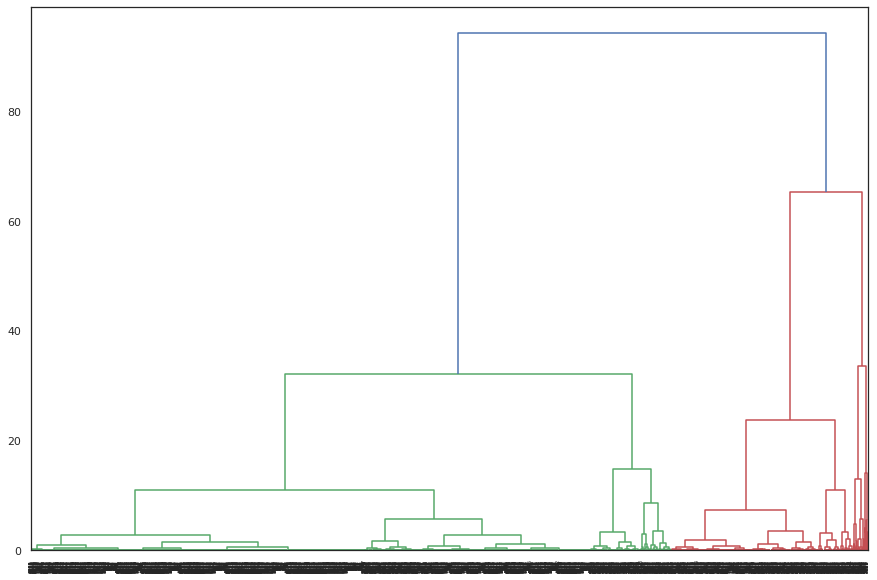

In [26]:
# создадим матрицу для кластеризации
X1 = freqs_users.loc[:, ['event', 'contacts']]
# стандартизация
sc = StandardScaler()
X1_sc = sc.fit_transform(X1)

# агломеративная кластеризация
linked_1 = linkage(X1_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked_1, orientation='top')
plt.show()

По графику видно, что выделяются 2 кластера. 

In [27]:
# задаём модель k_means с числом кластеров 2
km = KMeans(n_clusters = 2)
# прогнозируем кластеры для наблюдений
labels1 = km.fit_predict(X1_sc)

# сохраняем метки кластера в поле нашего датасета
freqs_users['cluster_freq'] = labels1

# выводим статистику по средним значениям наших признаков по кластеру
freqs_users.groupby('cluster_freq')['event', 'contacts'].agg(['count', 'mean'])

event            contacts          
             count       mean    count      mean
cluster_freq                                    
0             3306  13.794313     3306  0.000000
1              987  28.969605      987  0.993921

По частоте и совершению целевого действия пользователи разделились на две группы:
* 3306 человек, совершающие в среднем по 14 действий, и не совершающие целевое;
* 987 человек, совершающие по 29 действий в среднем, и чаще совершающие целевое. 

### Вывод

* Сегментация пользователей по RR - можно считать, что это деление пользователей на когорты. 
* Сегментация по общему времени и целевому действию:
  * 2996 человек попали в первый кластер, их среднее время пользования = 74885.92 сек (20.8 часов) и эти пользователи не совершают целевое действией;
  * 871 человек попали во второй кластер, их среднее время = 185959.6 (51.7 часов) и они чаще не совершают целевое действие;
  * 426 человек попадают в третий кластер, они пользуются в среднем по 1387344 секунд (385 часов) и они совершают целевое действие.
* Сегментация по частоте событий и целевому действию:
  * 3306 человек, совершающие в среднем по 14 действий, и не совершающие целевое;
  * 987 человек, совершающие по 29 действий в среднем, и чаще совершающие целевое.

## Проверка гипотез 
### Проверка гипотезы о разнице конверсий между пользователями, установившими приложение по ссылке из Yandex и Google (z-тест для сравнения долей)

**Нулевая гипотеза:** Конверсии пользователей в двух группах равны.

**Альтернативная гипотеза:** Конверсии пользователей в двух группах различаются.

In [28]:
# создадим функцию для рассчета z-теста 

def z_test(alpha, suc1, suc2, tr1, tr2):
    alpha = alpha # критический уровень статистической значимости
    successes = np.array([suc1, suc2])
    trials = np.array([tr1, tr2])
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0] 
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Доля успехов в первой группе', p1.round(3))
    print('Доля успехов во второй группе', p2.round(3))
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [29]:
# z-тест для сравнения доли пользователей, соверших целевое действие, к общему числу пользователей
# в группе
z_test(0.05, 
       conversion['goal_users'][0], 
       conversion['goal_users'][2], 
       conversion['all_users'][0], 
       conversion['all_users'][2])

Доля успехов в первой группе 0.244
Доля успехов во второй группе 0.247
p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверка гипотезы о разнице конверсий между пользователями с различной частотой использования приложения (z-тест для сравнения долей)

Используем 2 кластера, полученные в сегментации. 

In [30]:
# z-тест для сравнения доли пользователей, соверших целевое действие, к общему числу пользователей
# в группе по частоте использования приложения
rare_all = freqs_users.groupby('cluster_freq')['event'].count()[0]
often_all = freqs_users.groupby('cluster_freq')['event'].count()[1]
rare_goal = freqs_users.query('contacts == 1').groupby('cluster_freq')['event'].count()
often_goal = freqs_users.query('contacts == 1').groupby('cluster_freq')['event'].count()

z_test(0.05, 
       often_goal, 
       rare_goal, 
       often_all, 
       rare_all)

Доля успехов в первой группе [0.994]
Доля успехов во второй группе [0.297]
p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница


### Вывод

* Гипотезу о разнице конверсий между пользователями, установившими приложение по ссылке из Yandex и Google, принять не удалось. Значимых отличий нет;
* Гипотезу о разнице конверсий между пользователями, пользующихся приложением часто и редко, удалось подтвердить. Значимые отличия есть. Пользователи, которые часто пользуются приложением (совершают в среднем по 29 действий), чаще смотрят контакты в объявлениях;

## Выводы и рекомендации

1. Предобработка данных:
   * Был приведен к нужному типу столбец с датой и временем лога;
   * Был создан столбец с датой лога;
   * Значения "show_contacts" были заменены на "contacts_show";
   * Было посчитано общее время, проведенное пользователем в приложении (и переведено в часы и секунды).


2. Исследовательский анализ данных:
   * Большая часть пользователей проводят в приложении меньше 1 часа, поэтому в дальнейшем будем описаться на продолжительность сессии в секундах;
   * В среднем, пользователи проводят в приложении 2,6 дня или 227658 секунд;
   * Чаще всего пользователям предъявляют рекомендованные объявления, и они просматривают фотографии в объявлении и открывают карточки объявления;
   * Реже всего совершаются события, связанные с поиском по сайту.


3. Рассчет метрик:
   * В целом, наблюдается снижение RR с течением времени жизни когорты. Одна когорты 2019-10-12, 2019-10-19, 2019-10-22 демонстируют не такое большое снижение RR. Этот факт требует дальнейшего анализа. Необходимо понять, какие группы пользователей находятся в этих когортах и почему у них больше коэффициент возврата.
   * В некоторых когортах иногда наблюдается всплеск RR с последующим падением. Видим это в когортах 2019-10-11, 2019-10-17, 2019-10-21, 2019-10-25. Происходит всплеск на 3-4 день после начала пользования приложением.


4. Сегментация пользователей на основе метрик, общего времени и частоты действий:
   * Сегментация пользователей по RR - можно считать, что это деление пользователей на когорты.
   * Сегментация по общему времени и целевому действию:
     * 2996 человек попали в первый кластер, их среднее время пользования = 74885.92 сек (20.8 часов) и эти пользователи не совершают целевое действией; 
     * 871 человек попали во второй кластер, их среднее время = 185959.6 (51.7 часов) и они чаще не совершают целевое действие;
     * 426 человек попадают в третий кластер, они пользуются в среднем по 1387344 секунд (385 часов) и они совершают целевое действие.
   * Сегментация по частоте событий и целевому действию:
     * 3306 человек, совершающие в среднем по 14 действий, и не совершающие целевое;
     * 987 человек, совершающие по 29 действий в среднем, и чаще совершающие целевое.

5. Проверка гипотез:
   * Гипотезу о разнице конверсий между пользователями, установившими приложение по ссылке из Yandex и Google, принять не удалось. Значимых отличий нет;
   * Гипотезу о разнице конверсий между пользователями, пользующихся приложением часто и редко, удалось подтвердить. Значимые отличия есть. Пользователи, которые часто (в среднем, 29 действий) пользуются приложением, чаще смотрят контакты в объявлениях. 
   
В целом, заказчику можно порекомендовать обратить внимание на:
* не востребованность поиска в приложении;
* причины высокой степени захода в приложение пользователей из когорт 2019-10-12, 2019-10-19, 2019-10-22;
* причины всплеска активности на 3-4 день у пользователей из когорт 2019-10-11, 2019-10-17, 2019-10-21, 2019-10-25. 
* результаты сегментации: пользователи, со среднем временем использования приложения 385 часов и соверщающие по 29 действий в нем, чаще совершают целевое действие. 